In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importing scikit-learn modules for model building, preprocessing, and evaluation

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans



In [3]:

# Step 1: Load the dataset
df = pd.read_csv("/content/Crop_recommendation.csv")


In [4]:
# Preview first 5 rows
print(df.head())


    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


In [5]:
 # Check column names
print(df.columns)


Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')


In [6]:
# Step 2: Feature and label separation
X = df.drop("label", axis=1)  # all input features
y = df["label"]              # target/output label


In [7]:
# Step 3: Encode categorical labels into numeric format
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [8]:
# Step 4: Basic data exploration
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)


Shape of dataset: (2200, 8)

Data types:
 N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object


In [9]:
 # Check for missing values
print(df.isnull().sum())


N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [10]:
# Count duplicate rows

print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates() # Step 5: Remove duplicate entries to clean data


Duplicates: 0


/tmp/ipython-input-11-1724313155.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order=df['label'].value_counts().index, palette='viridis')


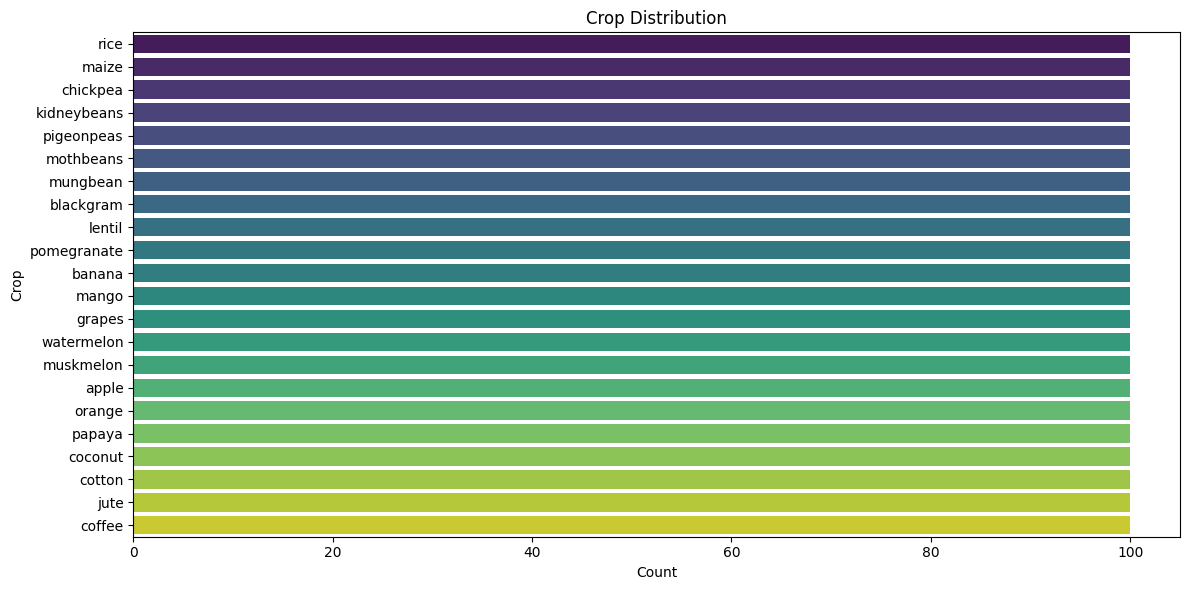

In [11]:
# Step 6: Plot the count of each crop to visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index, palette='viridis')
plt.title("Crop Distribution")
plt.xlabel("Count")
plt.ylabel("Crop")
plt.tight_layout()
plt.show()


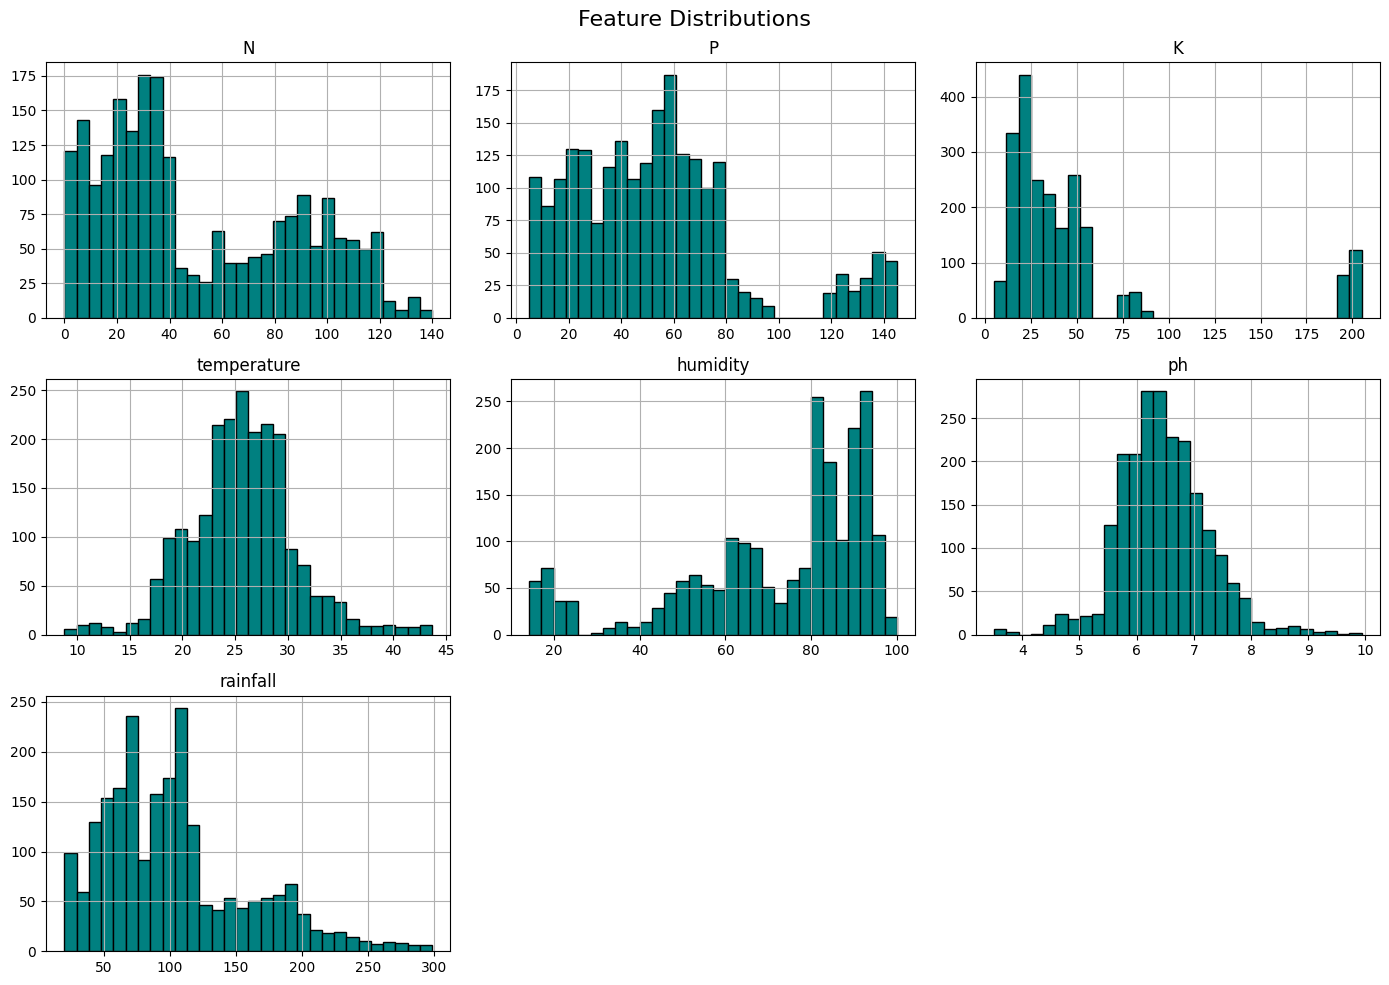

In [12]:
# Step 7: Plot histograms of all features to understand their distributions
df.drop("label", axis=1).hist(bins=30, figsize=(14, 10), color='teal', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


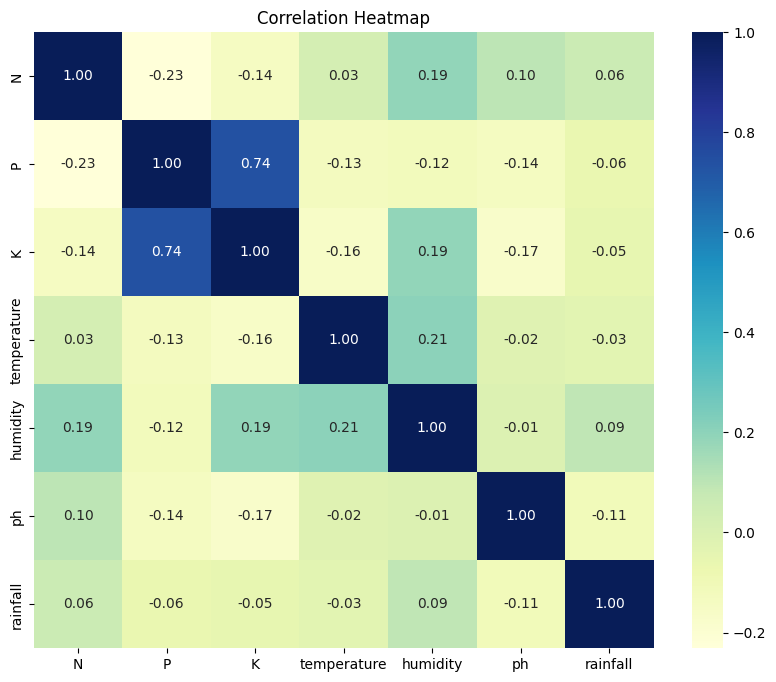

In [13]:
# Step 8: Correlation heatmap between numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop("label", axis=1).corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


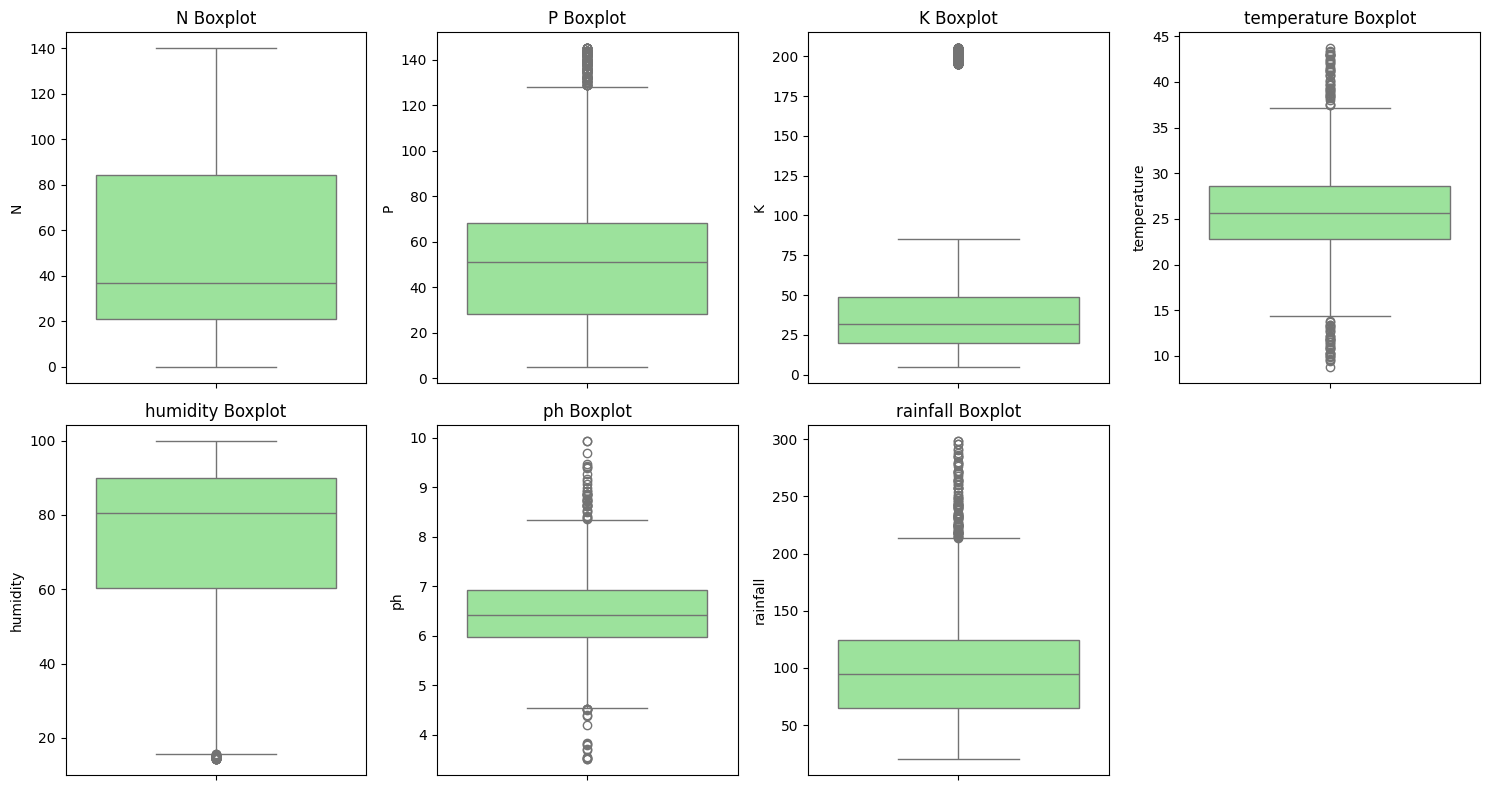

In [14]:
# Step 9: Boxplots to detect outliers in each feature
plt.figure(figsize=(15, 8))
for idx, col in enumerate(df.columns[:-1]):  # exclude label
    plt.subplot(2, 4, idx+1)
    sns.boxplot(data=df, y=col, color='lightgreen')
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()


In [15]:
# Step 10: Splitting data into training and testing sets (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [16]:
# Step 11: Standardizing features using z-score normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [17]:
# Step 12: Logistic Regression model
logr = LogisticRegression(max_iter=1000)
logr.fit(X_train_scaled, y_train)
y_pred_logr = logr.predict(X_test_scaled)


In [18]:
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_logr))


=== Logistic Regression ===
Accuracy: 0.9727272727272728


In [19]:
# Step 13: Linear Regression model (not ideal for classification, but used for comparison)
linr = LinearRegression()
linr.fit(X_train_scaled, y_train)
y_pred_linr = linr.predict(X_test_scaled)

In [20]:
y_pred_linr_round = np.clip(np.round(y_pred_linr).astype(int), 0, len(le.classes_) - 1)

print("\n=== Linear Regression (rounded to classes) ===")
print("Approx. Accuracy:", accuracy_score(y_test, y_pred_linr_round))



=== Linear Regression (rounded to classes) ===
Approx. Accuracy: 0.08636363636363636


In [21]:
# Step 14: Support Vector Machine (SVM) Classifier
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("\n=== SVM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))



=== SVM ===
Accuracy: 0.9840909090909091


In [22]:
# Step 15: K-Means Clustering (unsupervised model) + mapping clusters to labels
k = len(np.unique(y_encoded))
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans.fit(X_train_scaled)

KMeans(n_clusters=22, random_state=42)

In [23]:
# Step 16: Assign the majority class label to each cluster
from collections import Counter
cluster_to_label = {}
for c in range(k):
    # indices of samples in this cluster (on TRAIN set)
    idx = np.where(kmeans.labels_ == c)[0]
    if len(idx) == 0:
        cluster_to_label[c] = 0  # fallback
        continue
    majority_label = Counter(y_train[idx]).most_common(1)[0][0]
    cluster_to_label[c] = majority_label

In [24]:
# Step 17: Predict using KMeans on test data and convert clusters to label predictions
clusters_test = kmeans.predict(X_test_scaled)
y_pred_kmeans = np.vectorize(cluster_to_label.get)(clusters_test)

print("\n=== K-Means (cluster -> majority-class mapped) ===")
print("Approx. Accuracy:", accuracy_score(y_test, y_pred_kmeans))


=== K-Means (cluster -> majority-class mapped) ===
Approx. Accuracy: 0.7363636363636363


In [25]:
# Step 18: Making a prediction on a new sample input
new_sample = np.array([[90, 42, 43, 20.879744, 82.002744, 6.502985, 202.935536]])
new_sample_scaled = scaler.transform(new_sample)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [26]:
# Predict using SVM and decode back to crop name
pred_class_id = svm.predict(new_sample_scaled)[0]          # or logr.predict(...)
pred_class_name = le.inverse_transform([pred_class_id])[0]
print("\nPredicted crop for the sample:", pred_class_name)


Predicted crop for the sample: rice
